In [1]:
from sabr import SABR
from sabr_calibration import SABRCalibrator

from heston import Heston
from heston_calibration import HestonCalibrator

import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Option parameters:

F = 91.4
K = F

T = 2.0

r = 0.0

Nk = 15

Kn = K * np.linspace(0.5, 1.5, Nk)

Nt = 3

Tn = np.linspace(0.4, 1.0, Nt) * T

Kmesh, Tmesh = np.meshgrid(Kn, Tn)

Kmesh = Kmesh.reshape(-1)
Tmesh = Tmesh.reshape(-1)

In [3]:
from heston_calibration import gen_random_heston_params

In [4]:
#heston parameters
v_0 = 0.01
theta = 0.02
rho = -0.1
k = 2.0
sigma = 0.23

heston_params = np.asarray([v_0, theta, rho, k, sigma])

In [5]:
heston = Heston(heston_params, r, 200)

ch, ivh = heston(Kmesh, F, Tmesh)

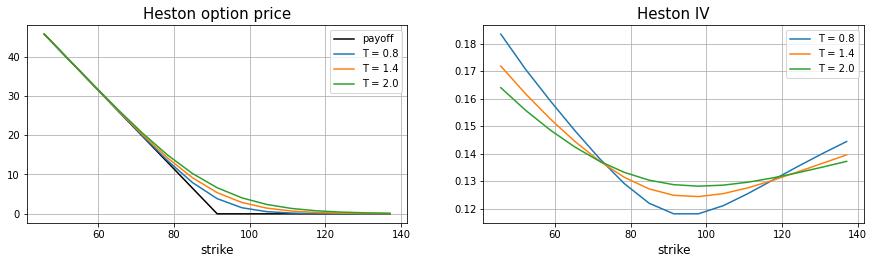

In [6]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(Kn, np.maximum(0, F - Kn), '-k', label='payoff')
for t in Tn:
    i = Tmesh == t
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(Kmesh[i], ch[i], label=f'T = {t}')
    ax1.grid()
    ax1.set_title("Heston option price", fontsize=15)
    ax1.set_xlabel("strike", fontsize=12)
    ax1.legend()

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(Kmesh[i], ivh[i], label=f'T = {t}')
    ax2.grid()
    ax2.set_title("Heston IV", fontsize=15)
    ax2.set_xlabel("strike", fontsize=12)
    ax2.legend()
None

### Calibration to heston data

In [7]:
heston_calib = HestonCalibrator(interest_rate=r, n_dim=1, n_int=200)

In [8]:
#calibrating sabr to heston
fs = heston_calib.fit(ch, Kmesh, F, Tmesh, Niter=60, typ=True)

 42%|██████████████████████████████████████████████████████████████████████                                                                                                  | 25/60 [00:00<00:00, 35.46it/s]


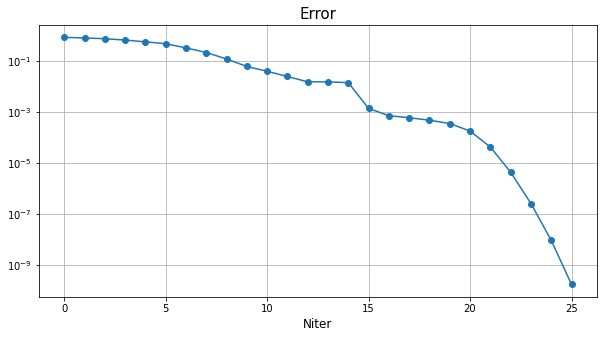

In [9]:
#plot result
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-o')
plt.title("Error", fontsize=15)
plt.xlabel("Niter", fontsize=12)
plt.grid()

In [10]:
names = ["v_0", "theta", "rho", "k", "sigma"] * (len(heston_params) // 5)

print('\tinitial\t \tcalibrated')
for name, param_0, param in zip(names, heston_params, heston_calib.heston_params):
    print(f"{name}:\t{param_0:.4f}\t\t{param:.4f}")

	initial	 	calibrated
v_0:	0.0100		0.0100
theta:	0.0200		0.0200
rho:	-0.1000		-0.1000
k:	2.0000		2.0000
sigma:	0.2300		0.2300


## Calibration to sabr

In [12]:
#sabr model parameters
alpha = 1.9
v = 0.9
beta = 0.5
rho = 0.5

sabr_params = np.asarray([alpha, v, beta, rho])

#sabr model
sabr = SABR(sabr_params, r)

cs, ivs = sabr( Kmesh, F + 1e-10, Tmesh )

In [13]:
heston_params

array([ 0.01,  0.02, -0.1 ,  2.  ,  0.23])

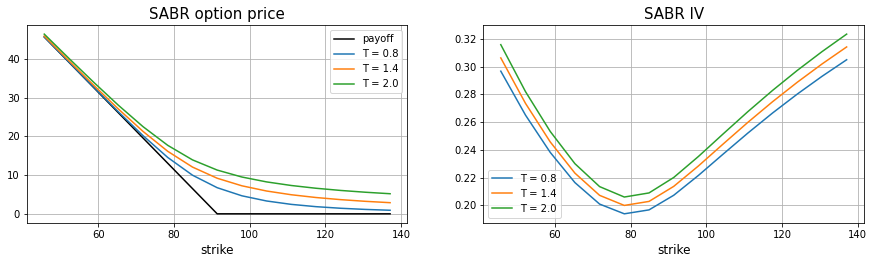

In [14]:
plt.figure(figsize=(15, 8))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(Kn, np.maximum(0, F - Kn), '-k', label='payoff')
for t in Tn:
    i = Tmesh == t
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(Kmesh[i], cs[i], label=f'T = {t}')
    ax1.grid()
    ax1.set_title("SABR option price", fontsize=15)
    ax1.set_xlabel("strike", fontsize=12)
    ax1.legend()

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(Kmesh[i], ivs[i], label=f'T = {t}')
    ax2.grid()
    ax2.set_title("SABR IV", fontsize=15)
    ax2.set_xlabel("strike", fontsize=12)
    ax2.legend()
None

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.94it/s]


0.02339944560061983


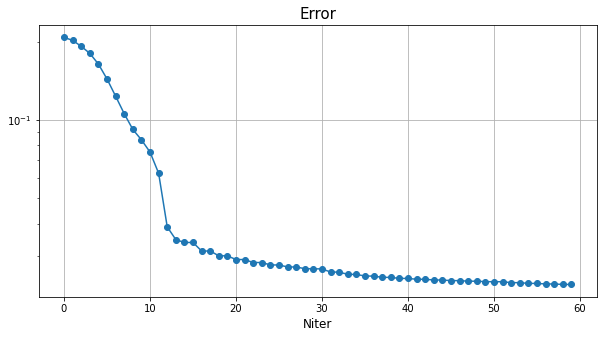

In [15]:
heston_calib = HestonCalibrator(interest_rate=r, n_dim=1, n_int=200)
#calibrating sabr to heston
fs = heston_calib.fit(cs, Kmesh, F, Tmesh, Niter=60, typ=True)

#plot result
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-o')
plt.title("Error", fontsize=15)
plt.xlabel("Niter", fontsize=12)
plt.grid()


print(fs[-1])

In [16]:
names = ["v_0", "theta", "rho", "k", "sigma"] * (len(heston_calib.heston_params) // 5)

for name, param in zip(names,heston_calib.heston_params):
    print(f"{name}:\t{param:.4f}")

v_0:	0.0409
theta:	0.6139
rho:	0.4352
k:	0.0572
sigma:	0.6182


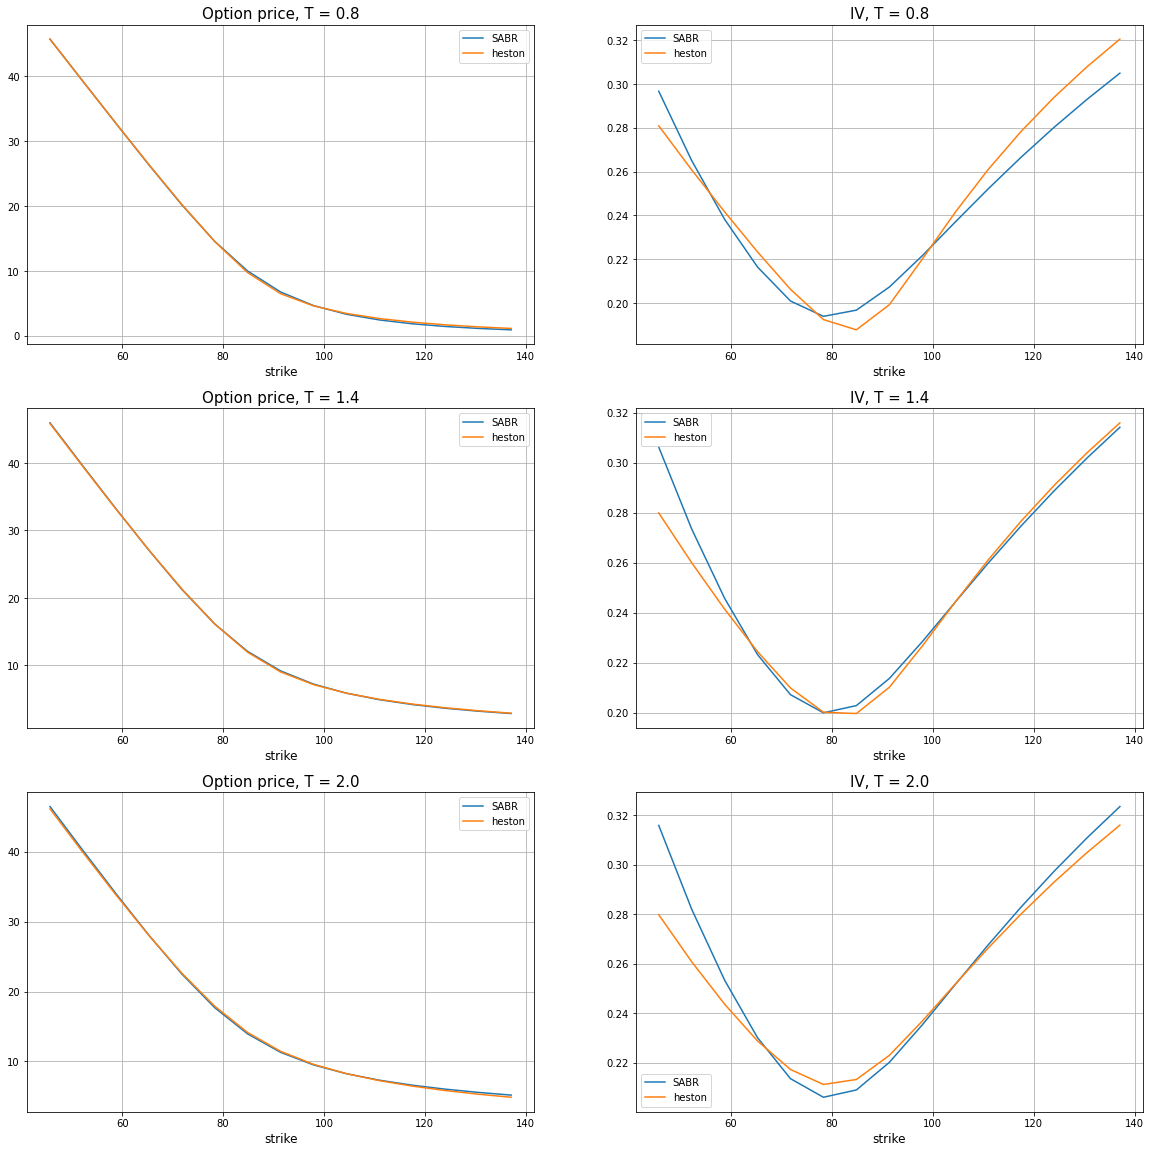

In [18]:
plt.figure(figsize=(20, 20))
j = 0
for t in Tn:
    i = Tmesh == t
    
    c_predict, iv_predict = heston_calib.predict(Kmesh[i], F, t)
    ax1 = plt.subplot(3, 2, 2 * j + 1)
    ax1.plot(Kmesh[i], cs[i], label='SABR')
    ax1.plot(Kmesh[i], c_predict, label='heston')
    ax1.grid()
    ax1.set_title(f"Option price, T = {t}", fontsize=15)
    ax1.set_xlabel("strike", fontsize=12)
    ax1.legend()

    ax2 = plt.subplot(3, 2, 2 * j + 2)
    
    ax2.plot(Kmesh[i], ivs[i], label='SABR')
    ax2.plot(Kmesh[i], iv_predict, label='heston')
    ax2.grid()
    ax2.set_title(f"IV, T = {t}", fontsize=15)
    ax2.set_xlabel("strike", fontsize=12)
    ax2.legend()
    j += 1
None